# Carregar Imagem

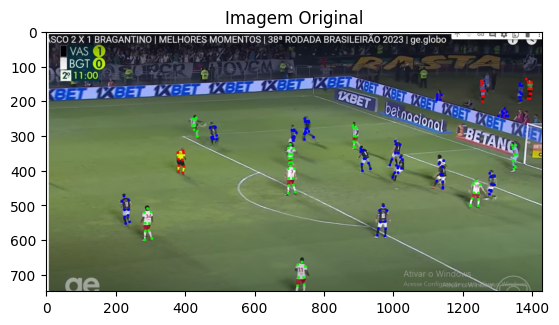

In [37]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import minimize

# Carregar a imagem
image_path = './img_exemplo.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertendo para RGB para exibição correta no Matplotlib

# Exibir a imagem
plt.imshow(image)
plt.title('Imagem Original')
plt.show()


# Conversão para HSV e Segmentação de Cor


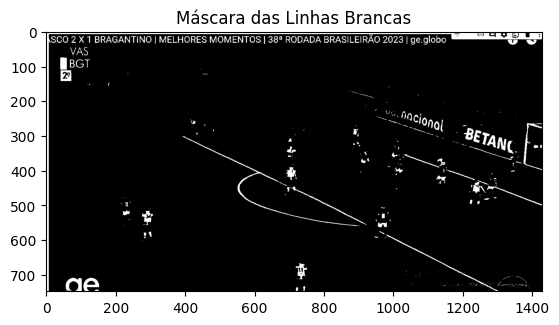

In [38]:
# Conversão para HSV
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)    # hue, saturation, value

# Definir faixa de cor para branco
lower_white = np.array([0, 0, 160]) # Representa o branco mais escuro
upper_white = np.array([180, 55, 255]) # Representa o branco mais claro
mask = cv2.inRange(hsv, lower_white, upper_white)

# Exibir a máscara
plt.imshow(mask, cmap='gray')
plt.title('Máscara das Linhas Brancas')
plt.show()

# Operações morfológicas

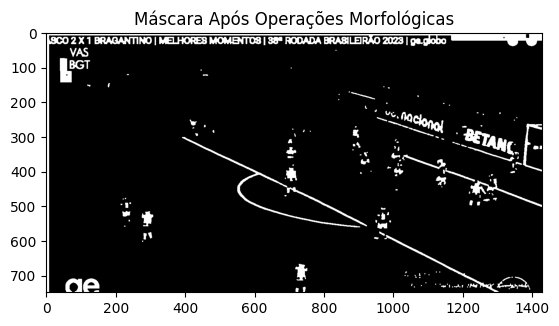

In [39]:
# Crie o kernel para operações morfológicas
kernel_size = 3  # Tente com 3x3 primeiro
kernel = np.ones((kernel_size, kernel_size), np.uint8)

# Dilatação para engrossar as linhas um pouco
mask_dilated = cv2.dilate(mask, kernel, iterations=1)

# Fechamento para conectar as linhas
mask_closed = cv2.morphologyEx(mask_dilated, cv2.MORPH_CLOSE, kernel)

# Exibir a máscara após operações morfológicas
plt.imshow(mask_closed, cmap='gray')
plt.title('Máscara Após Operações Morfológicas')
plt.show()


# Transformada de Hough para Linhas

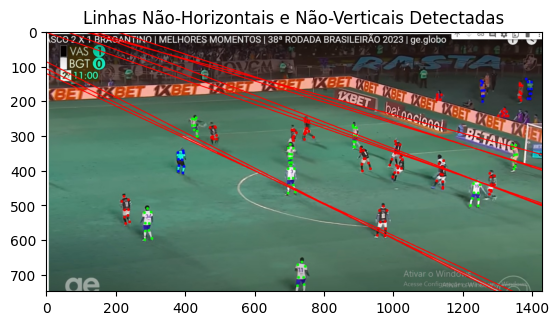

In [40]:
# Transformada de Hough para detectar linhas
threshold = 350  # Sistema de votos do algoritmo
lines = cv2.HoughLines(mask_closed, 1, np.pi / 180, threshold)

filtered_lines = []  # Inicialize o vetor de linhas filtradas

# Desenhar linhas na imagem com base na filtragem de orientação
if lines is not None:
    for line in lines:
        rho, theta = line[0]
        # Filtro de orientação: descarta linhas verticais e horizontais
        # A condição foi invertida para excluir linhas próximas de vertical ou horizontal
        if not (abs(theta) < 0.15 or abs(theta - np.pi/2) < 0.15 or abs(theta - np.pi) < 0.15):
            filtered_lines.append(line)  # Adicionar à lista de linhas filtradas
                        
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 4000 * (-b))
            y1 = int(y0 + 4000 * (a))
            x2 = int(x0 - 4000 * (-b))
            y2 = int(y0 - 4000 * (a))

            cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Exibir a imagem com as linhas sobrepostas
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Linhas Não-Horizontais e Não-Verticais Detectadas')
plt.show()

# Encontrar o ponto de interseção 

C:\Users\danie\AppData\Local\Temp\ipykernel_29288\1940884290.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [int(np.round(x0)), int(np.round(y0))]


Ponto de convergência: [-439.61110102 -159.94444412]


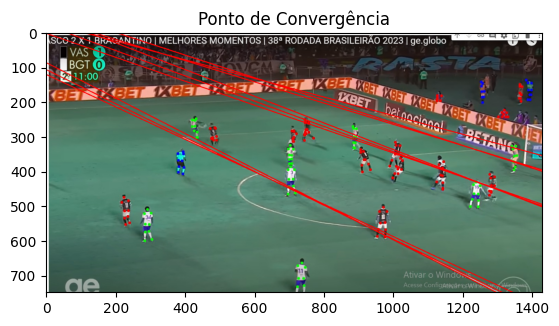

In [41]:
def line_intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    return [int(np.round(x0)), int(np.round(y0))]

def find_convergence_point(intersections):
    # Define a função de custo como a soma das distâncias quadráticas aos pontos de interseção
    def cost_function(point):
        return sum((point[0] - x)**2 + (point[1] - y)**2 for x, y in intersections)
    
    # Use a minimização para encontrar o ponto que minimiza a soma das distâncias quadráticas
    initial_guess = [image.shape[1] // 2, image.shape[0] // 2]
    result = minimize(cost_function, initial_guess, method='Powell')
    return result.x

# Supondo que 'filtered_lines' contém as linhas após filtragem
intersections = []
for i in range(len(filtered_lines)):
    for j in range(i+1, len(filtered_lines)):
        try:
            intersection = line_intersection(filtered_lines[i][0], filtered_lines[j][0])
            intersections.append(intersection)
        except np.linalg.LinAlgError:  # Se as linhas são paralelas, np.linalg.solve vai falhar
            pass

# Agora encontre o ponto de convergência usando todas as interseções coletadas
if intersections:
    convergence_point = find_convergence_point(intersections)
    print(f"Ponto de convergência: {convergence_point}")

    # Desenhar o ponto de convergência
    cv2.circle(image, (int(convergence_point[0]), int(convergence_point[1])), 10, (0, 255, 0), -1)

    # Exibir a imagem
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Ponto de Convergência')
    plt.show()


Testando o ponto de convergência obtido ao traçar possíveis linhas de impedimanto!

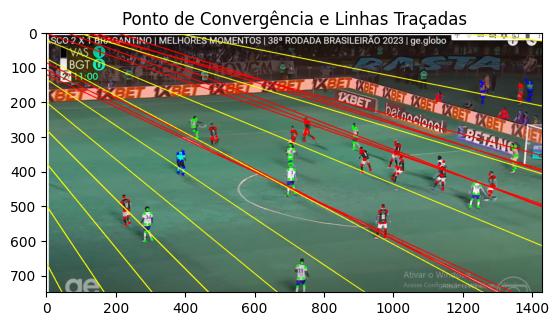

In [42]:
# Traçar retas variando apenas os ângulos a partir do ponto de convergência
number_of_lines = 64  # Número de linhas para traçar
for i in range(number_of_lines):
    angle = (2 * np.pi / number_of_lines) * i
    x0 = int(convergence_point[0])
    y0 = int(convergence_point[1])
    x1 = int(x0 + 4000 * np.cos(angle))
    y1 = int(y0 + 4000 * np.sin(angle))
    x2 = int(x0 - 4000 * np.cos(angle))
    y2 = int(y0 - 4000 * np.sin(angle))

    cv2.line(image, (x1, y1), (x2, y2), (0, 255, 255), 2)  # Linhas em amarelo

# Exibir a imagem com as linhas sobrepostas
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Ponto de Convergência e Linhas Traçadas')
plt.show()